In [1]:
from data import load_checks, load_objects

In [2]:
objects = load_objects('data')

In [3]:
import pandas as pd

In [4]:
from datetime import timedelta

def promo_start(date):
    # Cчитаем что все акции стартуют по четвергам
    # Определяем ближайший предыдущий четверг
    return date - timedelta(days=(date.isoweekday() - 4) % 7)

In [5]:
objects['promo_start'] = objects.start_date.apply(promo_start)

In [6]:
objects['selected_promo'] = objects['Promo_type'].isin(['Facades', 'Billboards'])

In [7]:
objects['length'] = (objects['end_date'] - objects['start_date']).apply(lambda x: 1+ x.days)

In [8]:
objects['selected_promo'] &= objects['length'] == 7

In [9]:
def explode_days(objects):
    objects['day'] = objects[['start_date', 'end_date']].apply(lambda x: pd.date_range(x['start_date'], x['end_date'], freq='D'), axis=1)
    return objects.explode('day')

objects = explode_days(objects)

In [10]:
objects.columns

Index(['Promo_type', 'Offer_ID', 'sku', 'start_date', 'end_date',
       'train_test_group', 'promo_start', 'selected_promo', 'length', 'day'],
      dtype='object')

In [11]:
full_checks = load_checks('data')
checks = full_checks.copy()

In [12]:
# Смотрим только продажи товаров которые присутствовали в интересующих нас промо 
checks = checks.merge(objects[objects['selected_promo'] == True][['sku']].drop_duplicates(), on='sku')
checks.shape

(2891363, 14)

In [13]:
checks = checks.merge(
    objects[['sku', 'day', 'selected_promo', 'Promo_type', 'Offer_ID']],
    on=['sku', 'day'],
    how='left',
)

In [14]:
checks['promo_start'] = checks['day'].apply(promo_start)

In [15]:
sku_promo_sales = checks.groupby(['sku', 'promo_start']).agg(
    {
        'promo_id': 'count',
        'sales': 'sum',
        'supplier_sales': 'sum',
        'num_sales': 'sum',
        'Promo_type': 'first',
        'Offer_ID': 'first',
        'selected_promo': 'first',
    }
)

In [16]:
sku_promo_sales = sku_promo_sales.rename({'promo_id': 'count_checks'}, axis=1)

In [17]:
sku_promo_sales['margin'] = sku_promo_sales['sales'] - sku_promo_sales['supplier_sales']

In [18]:
sku_promo_sales['price'] = sku_promo_sales['sales'] / sku_promo_sales['num_sales']

In [19]:
sku_promo_sales['item_margin'] = sku_promo_sales['margin'] / sku_promo_sales['num_sales']

In [20]:
sku_promo_sales = sku_promo_sales.reset_index()

In [21]:
sku_promo_sales.groupby('sku').agg({'sales': 'sum'}).sort_values('sales', ascending=False).head(10)

,sales
sku,
7a8675a8f6988ebcbefd062fabaccc85,20535247.43
ef7bf412117548cb80b3f3b33a12977d,18043911.71
753e100607ecf3e68098739b81e0a645,17468244.77
c8ac520562ba934dd67cbf0f060c4252,8908282.29
33306ccd877e73c388652739869d3dc7,7381691.18
d50b11b02e15deace91e3b4602a78c5d,6263542.56
1accaece89aad30aeab8ee5a72a2ecf0,5908229.19
1cbaaeb2212bbbe9d458ca9b81d74db7,5584251.30
911d7361089a37c2a6488a548b4f06a8,5565465.33


In [22]:
median_price = sku_promo_sales.groupby('sku')['price'].rolling(17, center=True, min_periods=8).median().reset_index()['price']

In [23]:
sku_promo_sales['usual_price'] = median_price

In [24]:
regular = sku_promo_sales[sku_promo_sales['selected_promo'].isna()]

In [58]:
sku_regular_margin = regular.groupby('sku').agg({'margin': 'mean', 'sales': 'mean'}).sort_values('margin', ascending=False)

In [92]:
promo = sku_promo_sales[sku_promo_sales['selected_promo'] == True]

In [93]:
promo = promo.merge(sku_regular_margin, on='sku', suffixes=['', '_regular'])

In [94]:
promo['added_margin'] = promo['margin'] - promo['margin_regular']

<AxesSubplot:>

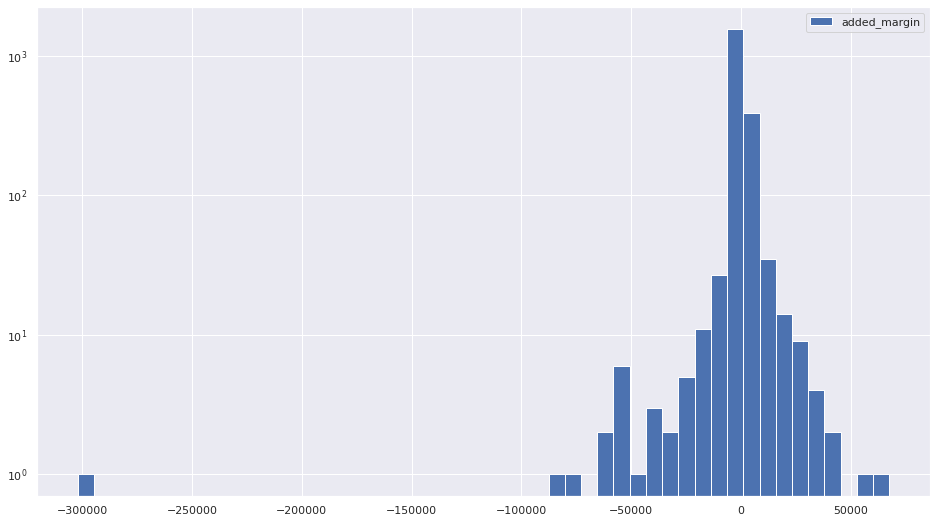

In [95]:
%matplotlib inline
import seaborn
seaborn.set()

promo['added_margin'].hist(bins=50, figsize=(16, 9), log=True, legend=True)

In [96]:
full_checks.columns

Index(['client_id', 'day', 'shop_id', 'check_id', 'time', 'sku', 'promo_id',
       'check_pos', 'num_sales', 'supplier_sales', 'sales', 'region_name',
       'retail_price', 'supplier_price'],
      dtype='object')

In [97]:
checks_count = full_checks.groupby(['day', 'check_id']).agg({'sales': 'sum'}).reset_index()

In [98]:
checks_count = checks_count.groupby('day').agg({'check_id': 'count'}).reset_index()

In [99]:
checks_count['promo_start'] = checks_count['day'].apply(promo_start)

<AxesSubplot:xlabel='promo_start'>

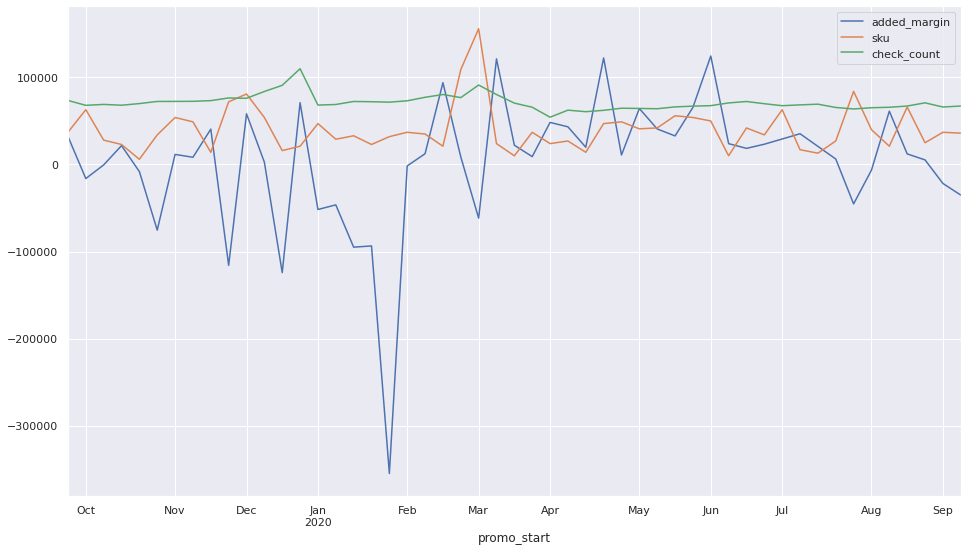

In [100]:
promo_grouped = promo.groupby('promo_start').agg({'added_margin': 'sum', 'sku': lambda x: 1000 * len(x)})
promo_grouped = promo_grouped.merge(checks_count.groupby('promo_start').agg({'check_id': 'sum'}).rename({'check_id': 'check_count'}, axis=1), on='promo_start')
promo_grouped['check_count'] *= 2
promo_grouped.plot(figsize=(16, 9))

In [68]:
sku_promo_sales['Promo_type'].value_counts()

Seasonal      2795
Biweekly      1937
Facades       1883
Billboards     558
Name: Promo_type, dtype: int64

In [83]:
promo_type = 'Biweekly'
promo = sku_promo_sales[sku_promo_sales['Promo_type'].isin([promo_type])]

In [84]:
promo = promo.merge(sku_regular_margin, on='sku', suffixes=['', '_regular'])

In [85]:
promo['added_margin'] = promo['margin'] - promo['margin_regular']

1931386.16264884


<AxesSubplot:>

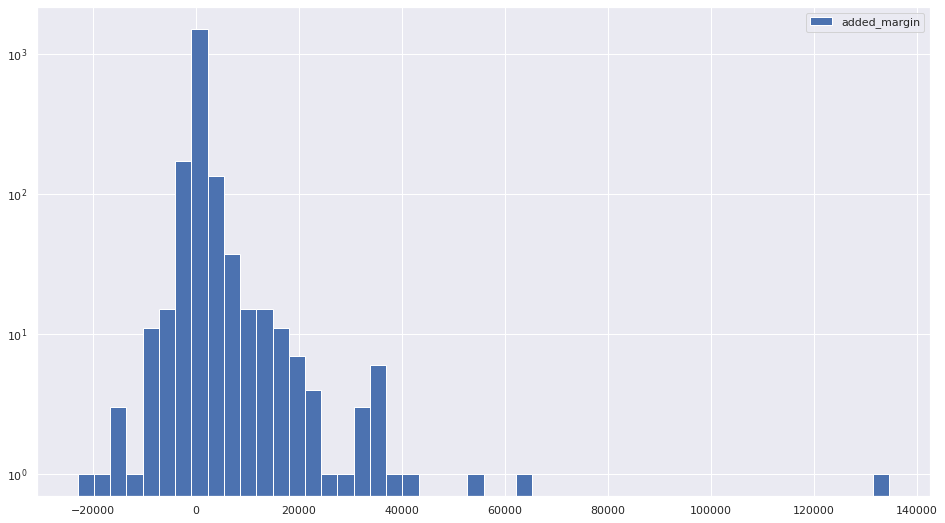

In [86]:
%matplotlib inline
import seaborn
seaborn.set()

print(promo['added_margin'].sum())
promo['added_margin'].hist(bins=50, figsize=(16, 9), log=True, legend=True)

In [89]:
promo[f'relative_added_margin, {promo_type}'] = promo['added_margin'] / promo['sales_regular']

<AxesSubplot:>

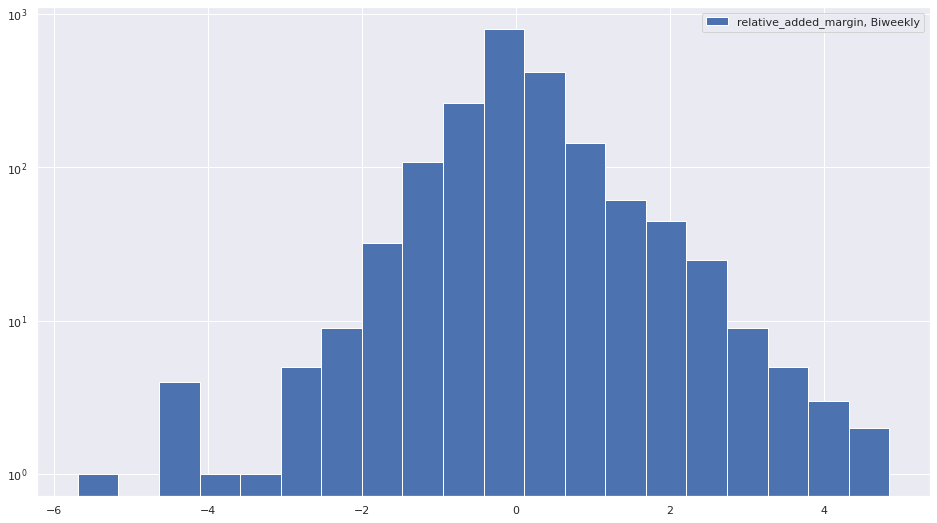

In [90]:
promo[f'relative_added_margin, {promo_type}'].hist(bins=20, log=True, figsize=(16, 9), legend=True)

In [ ]:
# План:

# Добавляем фичи: сколько недель от последнего промо
# Продаваемость товара (ранк)
# Маржинальность товара (ранк)
# Первая неделя промо (не хватает данных, надо больше года)
# Категория товара

In [ ]:
# Предсказываем для каждого из вариантов и оптимизируем календарь максимизируя added 